## The Locations API endpoint

This is an example of using the locations API endpoint. It can be used to get level2 data within certain radius of a location on the Earth during a certain time period.

See the [api docs](http://odin.rss.chalmers.se/apidocs/index.html?url=/rest_api/v4/spec#!/level2/get_rest_api_version_level2_project_locations) for specification of inputs and outputs for this endpoint.

#### Getting information on the products available
First we implement and run a small function for getting a list of the products that are available for the project `QSMRVDS`. This is done by making a *GET request* to the products endpoint URI of the API. The response from the API also includes the number of data points available for each product:

In [3]:
import requests


def example_get_project_overview(project="QSMRVDS"):
    """Get project overview"""
    r = requests.get(
        "http://odin.rss.chalmers.se/rest_api/v4/level2/{0}/products".format(project))
    return r.json()

In [4]:
example_get_project_overview()

{u'Info': {u'Products': {u'ClO / 501 GHz / 20 to 50 km': 248215,
   u'H2O-dummy / 501 GHz': 12,
   u'N2O / 502 GHz / 20 to 50 km': 564125,
   u'O3 / 501 GHz / 20 to 50 km': 564125,
   u'O3-dummy / 501 GHz': 88}}}

We will be looking at the O3 product in this demo:

In [5]:
PRODUCT = "O3 / 501 GHz / 20 to 50 km"

#### Getting data around location
Next we implement a function for getting data for a given period within a 1000 km radius of Frascati, Italy. The data call also requires either a pressure or an altitude range, which we set to the default range for the O3 product: 20 km - 50 km. The *GET request* is a little more complicated in this instance.

*(The altitude range, radius and location could of course have been arguments to the function instead, but lets keep it simple. For the interested reader it might be worth noting that Gothenburg is located at latitude 57.7 and longitude 11.97)*

In [7]:
def example_data_for_location(product=PRODUCT, start="2010-11-01",
                              end="2010-12-01"):
    """Get product for a radius of 1000 km centered on Frascati for period"""
    r = requests.get(
        "http://odin.rss.chalmers.se/rest_api/v4/level2/QSMRVDS/locations?"
        "radius={radius}&location={lat},{lon}&product={product}"
        "&min_altitude={min_alt}&max_altitude={max_alt}"
        "&start_time={start}&end_time={end}".format(
            product=product,
            lat=41.8166
            lon=12.683333,
            radius=1000,
            min_alt=20000,
            max_alt=50000,
            start=start,
            end=end,
        ))
    return r.json()

To inspect the data we import pprint, short for "pretty print" as a convenience:

In [15]:
from pprint import pprint


data = example_data_for_location(PRODUCT)
print "Number of data points:", data['Info']['Nr']
print "Example data:"
pprint(data['Info']['Results'][0])

Number of data points: 31
Example data:
{u'AVK': [-4.6382884334358357e-08,
          -2.289270553356654e-06,
          -4.238271996941165e-05,
          -0.0001402517130486291,
          -0.00015055234893258343,
          -0.00011505544560503735,
          -7.786940851757872e-05,
          -8.307241658840858e-05,
          -0.00010559738766274327,
          6.47519685177161e-06,
          6.241526278354996e-05,
          -0.0008659590182972402,
          -0.004462326486218782,
          -0.011413490912467487,
          -0.015744724351826087,
          0.005143879489222251,
          0.07564531562946672,
          0.192630262137111,
          0.24344144331629067,
          0.13561460292263874,
          0.0765367996909842,
          0.05051990594907768,
          0.03481779325196905,
          0.020405885938144686,
          0.011402625831442498],
 u'Altitude': 48117.45602898654,
 u'Apriori': 3.353015766456828e-06,
 u'ErrorNoise': 5.460686009529726e-07,
 u'ErrorTotal': 5.547166661569419

#### Putting it together
Finally we put together a function that makes repeated calls to the previously defined function, aggregating the data for the specified years into monthly averages. The end results is a plot with errorbars as well as maximum and minimum values for the different months.

In [27]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np


def example_data_for_location_plot(product=PRODUCT, start_year=2001, endyear=2014):
    """Plot total product over time for region around Frascati"""
    delta = relativedelta(months=1)
    date = datetime(start_year, 1, 1)

    # Initialise varaibles:
    data = [[] for _ in range(12)]
    time = range(1, 13)
    
    # Loop over years
    year = start_year - 1
    while date.year <= endyear:
        if year != date.year:
            year = date.year
            print "Reading", year
        start = date.date().isoformat()
        end = (date + delta).date().isoformat()
        
        # Get data by calling our previously defined function:
        raw_data = example_data_for_location(product, start, end)

        data[date.month - 1].extend(
            [
                d['VMR'] for d in raw_data['Info']['Results']
                if d['Quality'] is None
            ]
        )
        date += delta

    # Calculate statistics:
    stds = np.array([np.nanstd(d) for d in data])
    mins = np.array([np.nanmin(d) for d in data])
    maxs = np.array([np.nanmax(d) for d in data])
    data = np.array([np.nanmean(d) for d in data])

    # Create figure:
    plt.figure(1)
    plt.clf()
    
    plt.errorbar(time, 1e6*data, 1e6*stds, fmt='s--g', lw=2, ms=7, capsize=8,
                 capthick=2, label=r"$mean$")
    plt.plot(time, 1e6*mins, '-.b', lw=2, label=r"$min$")
    plt.plot(time, 1e6*maxs, '-.r', lw=2, label=r"$max$")

    plt.xlabel(r"$month$")
    plt.ylabel(r"$VMR(O_3) \cdot 1e6$")
    plt.legend(numpoints=1)
    
    plt.axis([0.5, 12.5, 0, 1e6*np.nanmax(data + 2*stds)])
    plt.grid(True)
    plt.xticks(range(1, 13), range(1, 13))

Reading 2005
Reading 2006
Reading 2007
Reading 2008
Reading 2009
Reading 2010
Reading 2011
Reading 2012
Reading 2013
Reading 2014


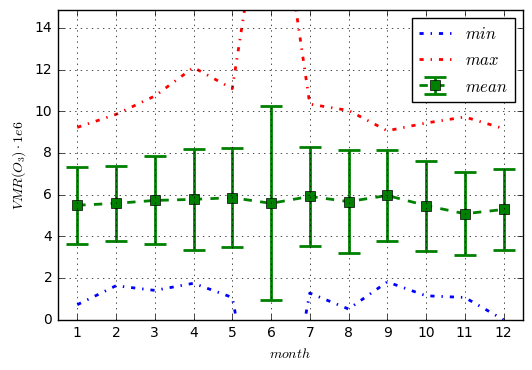

In [26]:
%matplotlib inline
example_data_for_location_plot(PRODUCT, 2005, 2014)